# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
print(customers.shape)
customers.head()

(440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### After checking the dataset additional info link and look the head, lets define clearly what we have:
 - Our dataset has 8 vars, 2 categorical (nominal) vars and the rest are sum of monetary units
 - Each row represents 1 client
 - Channel is 1=horeca, 2=retail
 - Region is 1=lisbon, 2=porto, 3=others
 - Therefore, joining all the info, we can say that the 1st client is a reailer from other region which has spent that diff monetary units in an specific year

#### The 1st thing we will do is trying to guess the number of clusters by a plot

/home/diego/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


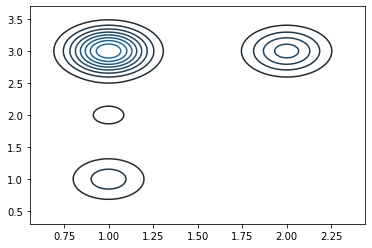

In [4]:
sns.kdeplot(customers)
plt.show() 

#### It looks clearly 4 or more but we don't exactly how many, so lets check the frequency of the categorical vars

In [5]:
#the frequency of channels and cities
print(customers.Channel.value_counts(),"\n")
print(customers.Region.value_counts())

1    298
2    142
Name: Channel, dtype: int64 

3    316
1     77
2     47
Name: Region, dtype: int64


#### As we see, if we don't include others metrics like avg spent in X product, our cluster number would be 6, as they told us in the additional info too

#### We are said there aren't nulls neither int vals, but lets check it, just in case 

In [6]:
# Your observations here
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [7]:
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

#### Now that we saw they didn't lie, lets separate categorical and numerical data, so we can use our categorical data in our clusterization methods

In [8]:
cat = customers[["Channel","Region"]]
cat = cat.replace({'Channel': {1: "horeca", 2: "retail"},"Region": {1:"lisbon",2:"porto",3:"other"}})
cat.head()

,Channel,Region
0,retail,other
1,retail,other
2,retail,other
3,horeca,other
4,retail,other


In [9]:
num = customers.drop(columns=["Channel","Region"])
num.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [10]:
for col in cat:
    dummies = pd.get_dummies(customers[col], prefix=col)
    customers = pd.concat([customers, dummies], axis=1)
    customers.drop(col, axis=1, inplace=True)
    
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


#### Lets check the distribution of our data with stats funtions and plots

In [11]:
customers.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.0000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,0.677273,0.322727,0.1750,0.106818,0.718182
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,0.468052,0.468052,0.3804,0.309234,0.450397
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,1.000000,0.000000,0.0000,0.000000,1.000000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,1.000000,1.000000,0.0000,0.000000,1.000000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,1.000000,1.000000,1.0000,1.000000,1.000000


In [12]:
customers.skew()

Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
Channel_1           -0.760951
Channel_2            0.760951
Region_1             1.716532
Region_2             2.554556
Region_3            -0.973266
dtype: float64

*By checking the skew, mean and median we see delicassen distribution is highly right skewed (which is normal as it is not basic need). With frozen happens something similar, while the others are skewed too, but not that much. Lets plot them to have a better understanding of our data*

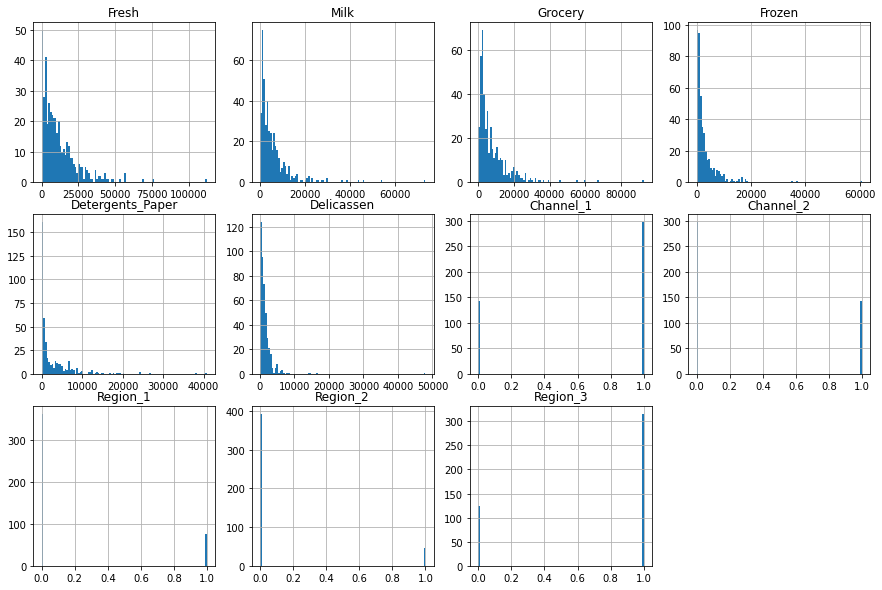

In [13]:
figure = plt.figure(figsize=(15,10))

for n, col in enumerate(customers.columns):
    ax=figure.add_subplot(3,4,n+1)
    ax.set_title(col)
    customers[col].hist(ax=ax, bins=100)
plt.show()

*We see diff scales of data. The biggest differences are betwen the categorical vars and the rest. So looks like our data shoud be normarlize or standardize or both*

Text(0.5, 1.0, 'Correlation matrix')

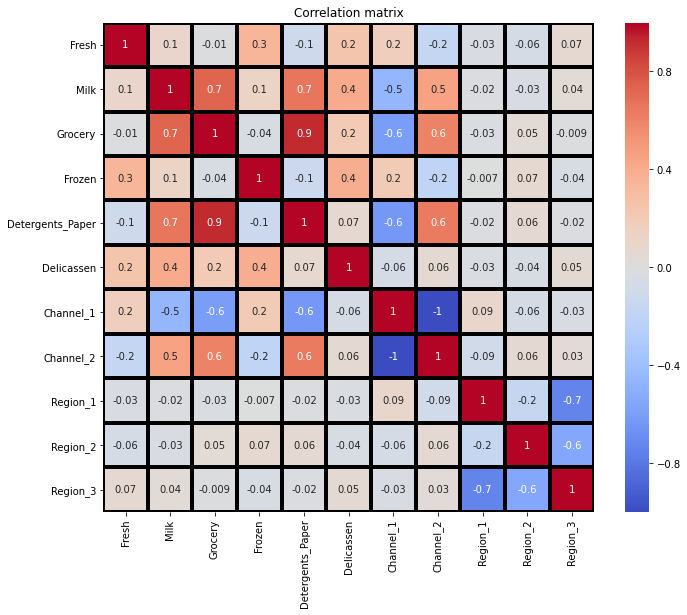

In [14]:
plt.figure(figsize=(11,9))

sns.heatmap(customers.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')

*With the corr matrix above we can see that detergents_paper and grocery are really correlated, which possibly will mean that almost each time people do groceries, they buy detergents or/and paper. Therefore as detergents_paper is included in groceries, we should test our model with and without detergents_paper*

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

##### So as we have seen before we have 2 biggest issues, an scale problem and a hight positive corr (0.9) between 2 variables. So 1st lets scales our df and 2nd, lets do two samples; one with detergents_paper and the other without it and check which have better results

##### As we are new in this field and our idea is to learn the diff ways of obtaining the best data to train our unsupervised model, we will try some scale model from --> https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

### 1. StandardScaler

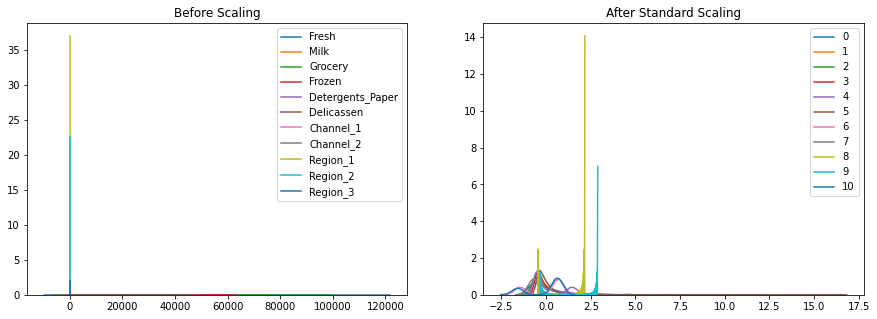

In [15]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

Xss = sc_X.fit_transform(customers)

customers_SS = pd.DataFrame(Xss)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After Standard Scaling')
for e in customers_SS.columns:
    sns.kdeplot(customers_SS[e], ax=ax2)
plt.show()

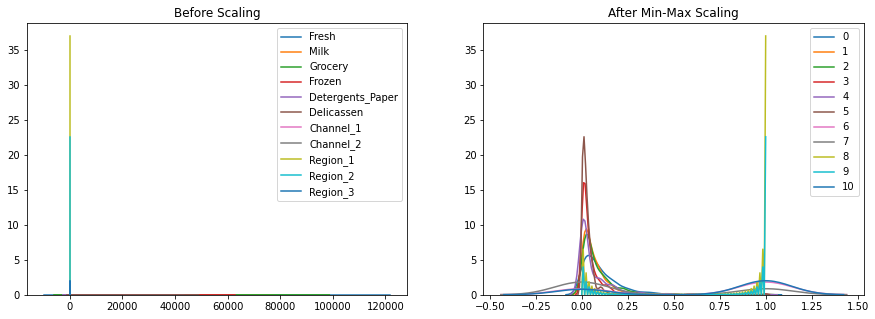

In [16]:
from sklearn.preprocessing import MinMaxScaler
mmc_X = MinMaxScaler()

Xmm = mmc_X.fit_transform(customers)

customers_MM = pd.DataFrame(Xmm)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After Min-Max Scaling')
for e in customers_MM.columns:
    sns.kdeplot(customers_MM[e], ax=ax2)
plt.show()

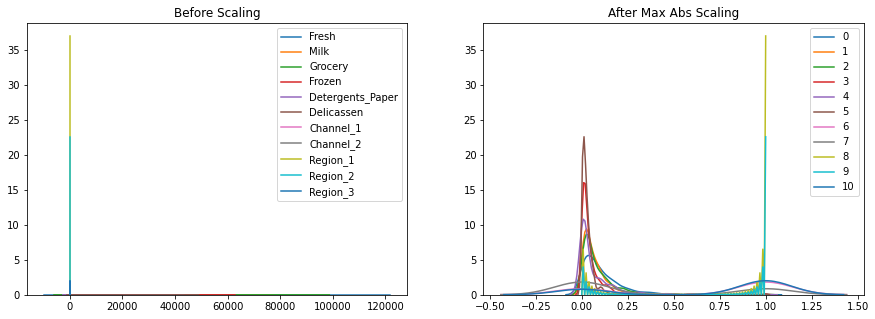

In [17]:
from sklearn.preprocessing import MaxAbsScaler
masc_X = MaxAbsScaler()

Xmasc = masc_X.fit_transform(customers)

customers_MASC = pd.DataFrame(Xmasc)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After Max Abs Scaling')
for e in customers_MASC.columns:
    sns.kdeplot(customers_MASC[e], ax=ax2)
plt.show()

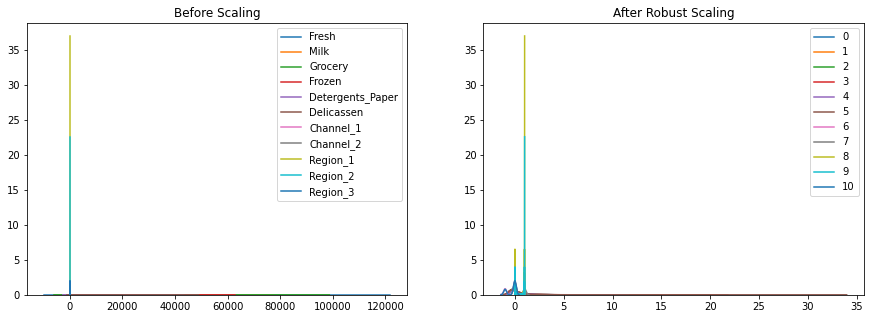

In [18]:
from sklearn.preprocessing import RobustScaler
rsc_X = RobustScaler()

Xrsc = rsc_X.fit_transform(customers)

customers_RSC = pd.DataFrame(Xrsc)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After Robust Scaling')
for e in customers_RSC.columns:
    sns.kdeplot(customers_RSC[e], ax=ax2)
plt.show()

In [19]:
for e in customers.values:
    if any(e<0):
        print("yes")

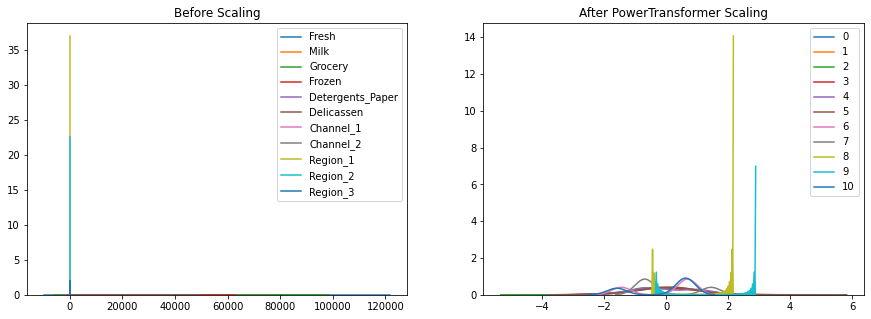

In [20]:
#default mode --> Yeo-Johnson
#Box-Cox mode --> if all data is positive is preferred
from sklearn.preprocessing import PowerTransformer
pt_X = PowerTransformer(method='yeo-johnson')

Xpt = pt_X.fit_transform(customers)

customers_PT = pd.DataFrame(Xpt)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After PowerTransformer Scaling')
for e in customers_PT.columns:
    sns.kdeplot(customers_PT[e], ax=ax2)
plt.show()

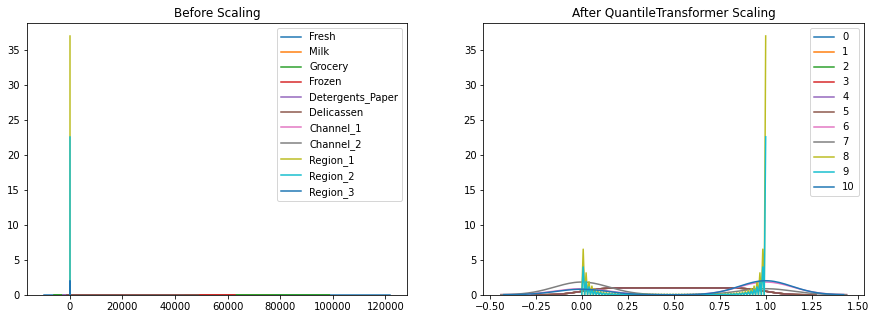

In [21]:
from sklearn.preprocessing import QuantileTransformer
qt_X = QuantileTransformer(n_quantiles=440,output_distribution='uniform',)

Xqt = qt_X.fit_transform(customers)

customers_QT = pd.DataFrame(Xqt)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in customers.columns:
    sns.kdeplot(customers[e], ax=ax1)
ax2.set_title('After QuantileTransformer Scaling')
for e in customers_QT.columns:
    sns.kdeplot(customers_QT[e], ax=ax2)
plt.show()

#### After checking almost all the scale methods, it looks like the one that fit best for our data is the Min Max Scaling

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [22]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

#### We will use 2 methods to determine the perfect number of cluster for our data

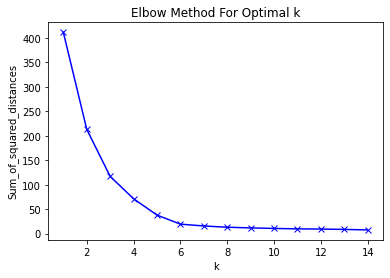

In [23]:
# Your code here:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
klusters = range(1,15)
for k in klusters:
    km = KMeans(n_clusters = k)
    km = km.fit(customers_MM)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(klusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

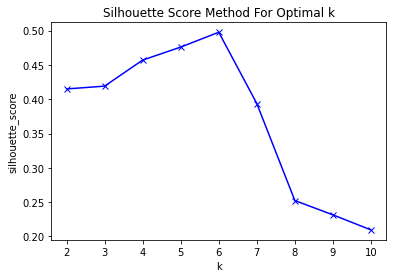

In [47]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(customers_MM)
    labels = km.labels_
    sil.append(silhouette_score(Xqt, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()

#### Although the Elbow method has told us the opti number is 5, we will use 6, as the Silhouette is more accurate

In [25]:
model = KMeans(n_clusters=6)

labels = model.fit_predict(customers_MM)

Count the values in `labels`.

In [26]:
# Your code here:
set(labels)

{0, 1, 2, 3, 4, 5}

In [27]:
customers["channel"] = cat.Channel
customers["region"] = cat.Region
customers["label"] = labels
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,channel,region,label
0,12669,9656,7561,214,2674,1338,0,1,0,0,1,retail,other,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1,retail,other,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1,retail,other,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1,horeca,other,0
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1,retail,other,1


In [28]:
customers.label.value_counts()

0    211
1    105
2     59
3     28
4     19
5     18
Name: label, dtype: int64

# PERFECT CLUSTERICING!

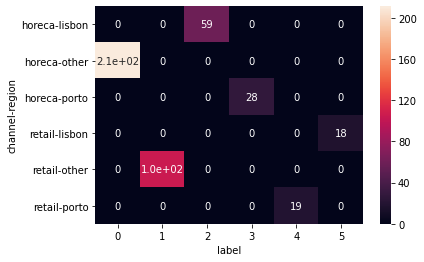

In [29]:
analysis = pd.crosstab([customers.channel, customers.region], customers.label)
sns.heatmap(analysis, annot=True)

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [30]:
# Your code here
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5).fit(customers_MM)
customers['labels_DBSCAN'] = clustering.labels_
set(customers['labels_DBSCAN'])

{-1, 0, 1, 2, 3, 4, 5}

Count the values in `labels_DBSCAN`.

In [31]:
# Your code here
customers['labels_DBSCAN'].value_counts()

 1    209
 0    102
 2     59
 5     27
 4     18
 3     18
-1      7
Name: labels_DBSCAN, dtype: int64

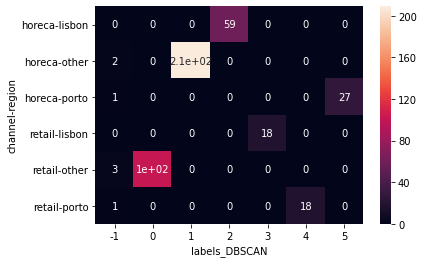

In [32]:
analysis = pd.crosstab([customers.channel, customers.region], customers.labels_DBSCAN)
sns.heatmap(analysis, annot=True)

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

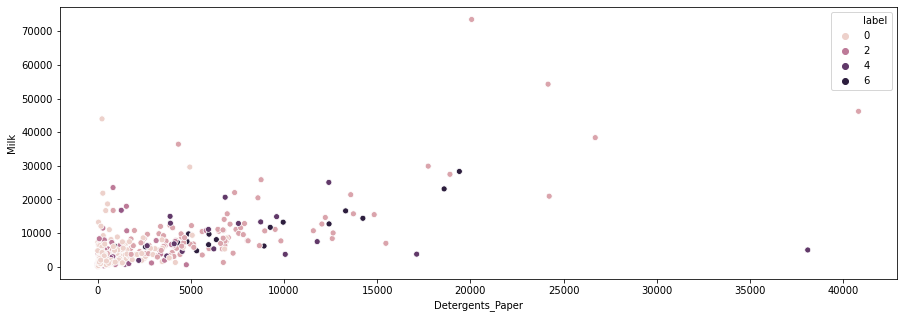

In [33]:
# Your code here:

plt.figure(figsize=(15,5))
sns.scatterplot("Detergents_Paper", "Milk", data=customers, hue="label")

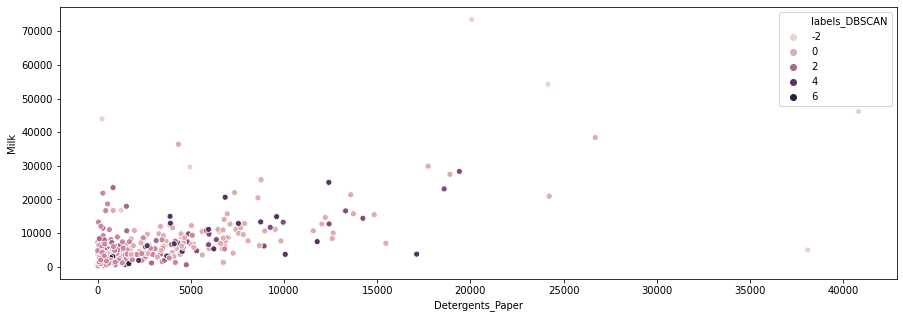

In [34]:
plt.figure(figsize=(15,5))
sns.scatterplot("Detergents_Paper", "Milk", data=customers, hue="labels_DBSCAN")

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

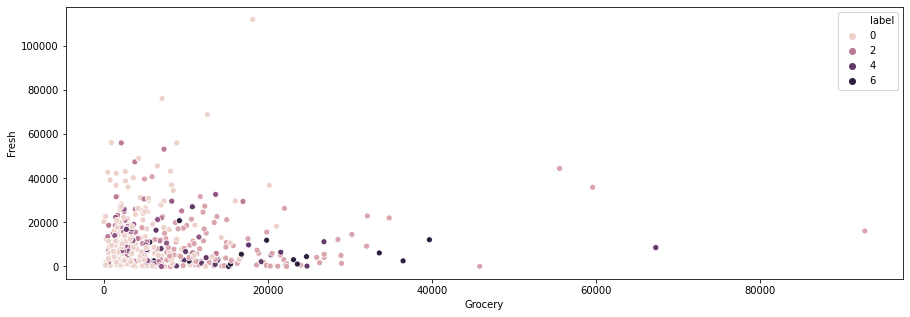

In [35]:
# Your code here:
plt.figure(figsize=(15,5))
sns.scatterplot("Grocery", "Fresh", data=customers, hue="label")

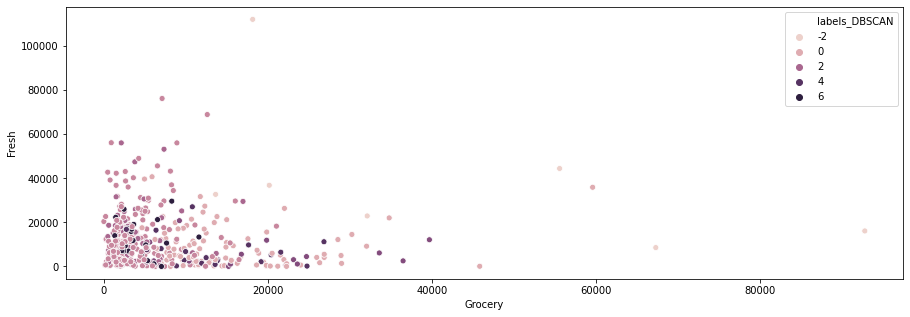

In [36]:
# Your code here:
plt.figure(figsize=(15,5))
sns.scatterplot("Grocery", "Fresh", data=customers, hue="labels_DBSCAN")

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

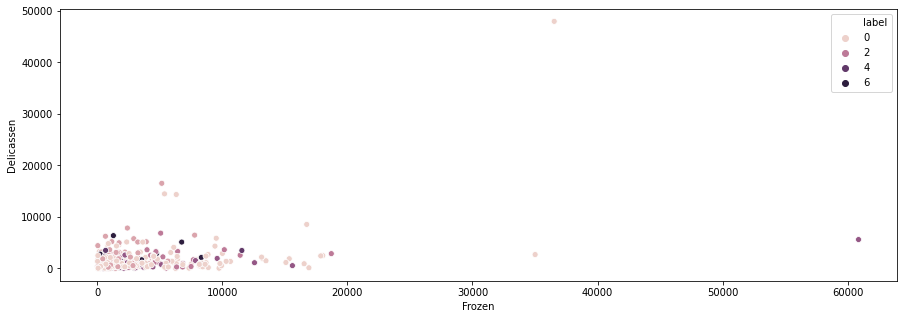

In [37]:
# Your code here:
plt.figure(figsize=(15,5))
sns.scatterplot("Frozen", "Delicassen", data=customers, hue="label")

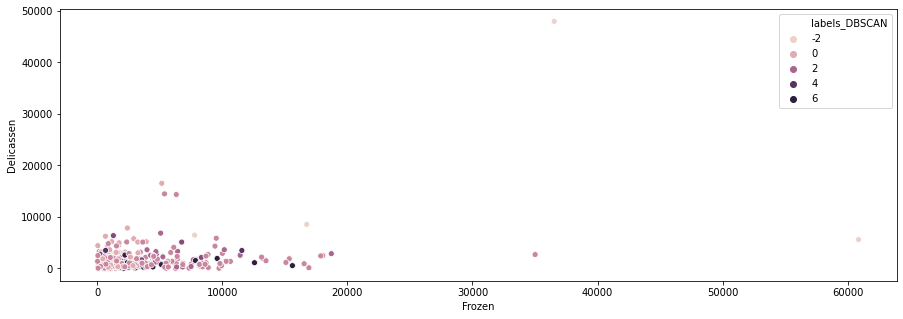

In [38]:
# Your code here:
plt.figure(figsize=(15,5))
sns.scatterplot("Frozen", "Delicassen", data=customers, hue="labels_DBSCAN")

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [39]:
# Your code here:
customers.groupby("label").mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,labels_DBSCAN
label,,,,,,,,,,,,
0,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360,1,0,0,0,1,0.981043
1,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524,0,1,0,0,1,-0.028571
2,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542,1,0,1,0,0,2.000000
3,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857,1,0,0,1,0,4.785714
4,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000,0,1,0,1,0,3.736842
5,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444,0,1,1,0,0,3.000000


In [40]:
customers.groupby("labels_DBSCAN").mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,label
labels_DBSCAN,,,,,,,,,,,,
-1,39112.571429,38470.714286,42815.285714,17724.857143,18518.428571,10518.428571,0.428571,0.571429,0.0,0.285714,0.714286,1.428571
0,9301.960784,9598.549020,14653.774510,1461.676471,6268.156863,1778.823529,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
1,13297.947368,3168.306220,3740.588517,3436.971292,769.392344,1262.511962,1.000000,0.000000,0.0,0.000000,1.000000,0.000000
2,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542,1.000000,0.000000,1.0,0.000000,0.000000,2.000000
3,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444,0.000000,1.000000,1.0,0.000000,0.000000,5.000000
4,7218.944444,9424.722222,13494.555556,1618.888889,6760.722222,1240.333333,0.000000,1.000000,0.0,1.000000,0.000000,4.000000
5,10870.296296,1767.962963,4053.629630,3703.407407,453.481481,939.111111,1.000000,0.000000,0.0,1.000000,0.000000,3.000000


Which algorithm appears to perform better?

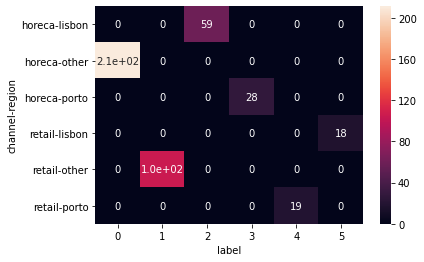

In [41]:
# Your observations here
analysis = pd.crosstab([customers.channel, customers.region], customers.label)
sns.heatmap(analysis, annot=True)

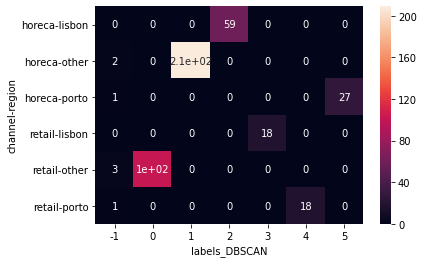

In [42]:
analysis = pd.crosstab([customers.channel, customers.region], customers.labels_DBSCAN)
sns.heatmap(analysis, annot=True)

#### We can see that K means has done a perfect clustericing and DBSCAN almost. However we didn't look for an opti number in eps

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [43]:
# Your code here
model = KMeans(n_clusters=4)

labels = model.fit_predict(customers_SS)
customers["label"] = labels

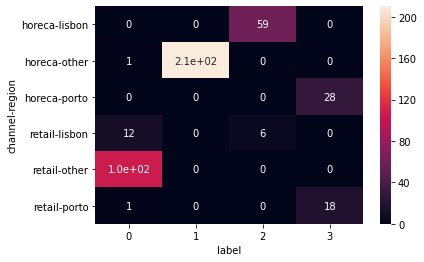

In [44]:
# Your observations here

analysis = pd.crosstab([customers.channel, customers.region], customers.label)
sns.heatmap(analysis, annot=True)

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [45]:
# Your code here
clustering = DBSCAN(eps=1.3).fit(customers_SS)
customers['labels_DBSCAN'] = clustering.labels_
set(customers['labels_DBSCAN'])

{-1, 0, 1, 2, 3, 4, 5}

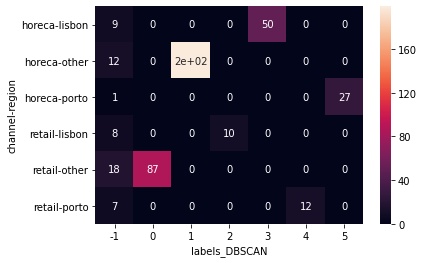

In [46]:
# Your comment here
analysis = pd.crosstab([customers.channel, customers.region], customers.labels_DBSCAN)
sns.heatmap(analysis, annot=True)